In [1]:
from SimPEG import *
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver

In [2]:
from simpegEMIP.TDEM import Problem3DEM_e
from simpegEMIP.TDEM import Rx
from simpegEMIP.TDEM import Survey
from simpegEMIP.Base import BaseEMIPProblem
from SimPEG import EM
csx, csz, ncx, ncz, npadx, npadz = 6.5, 5., 10, 20, 20, 20
hx = [(csx,ncx), (csx,npadx,1.3)]
hz = [(csz,npadz, -1.3), (csz,ncz), (csz,npadz,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sig_half = 0.1
sigmaInf = np.ones(mesh.nC) * sig_half
airind = mesh.gridCC[:,2]>0.
sigmaInf[airind] = 1e-8
src_z = 30.
rxloc = np.array([0., 0., src_z])
srcloc = np.array([0., 0., src_z])
rx = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
src = EM.TDEM.Src.CircularLoop([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius=13.)
survey = Survey([src])
prb_em = Problem3DEM_e(mesh, sigma=sigmaInf)
prb_em.verbose = False
prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_em.Solver = PardisoSolver
prb_em.pair(survey)
data = survey.dpred([])

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:399: UserWarning: Cannot add model as there are no active mappings, choose from: ['rhoMap', 'sigmaMap']
  "', '".join(self._all_map_names)


In [3]:
from simpegEM1D import EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, set_mesh_1d
import numpy as np
mesh1D = Mesh.TensorMesh([1])
TDsurvey = EM1DSurveyTD(
    rx_location = np.array([0., 0., src_z]),
    src_location = np.array([0., 0., src_z]),
    topo = np.r_[0., 0., 0.],
    offset = np.r_[0.],
    depth = np.r_[0.],
    rx_type = 'dBzdt',
    wave_type = 'stepoff',
    src_type = 'CircularLoop',
    a = 13.,
    I = 1.,
    time = rx.times.copy(),
    half_switch=True
)
expmap = Maps.ExpMap(mesh1D)
prob = EM1D(mesh1D, sigma=np.r_[sig_half])
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.chi = np.zeros(TDsurvey.n_layer)
dhzdt = TDsurvey.dpred([])

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:399: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'hMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


0.5820885371630571
[-1.10527739 -1.10658378 -0.99262652 -0.88142198 -0.82965631 -0.92919974
 -0.85746231 -0.91499614 -0.8949159  -0.85555547 -0.81857477 -0.85133668
 -0.89077167 -0.94682331 -0.94621701 -0.92894704 -0.90099292 -0.84876309
 -0.81482368 -0.75257705 -0.80539388 -0.83434476 -0.8258641  -0.82602053
 -0.78981653 -0.76740832 -0.73373039 -0.81415245 -0.83770661 -0.8373914
 -0.81262959 -0.78342342 -0.80350075 -0.81563945 -0.82437132 -0.78864311
 -0.73526762 -0.66043013 -0.67753302 -0.61810346 -0.55939149 -0.4697169
 -0.38767561 -0.33083325 -0.28555505 -0.22627222 -0.17083266 -0.12521004
 -0.09025223 -0.06348864 -0.04432283]


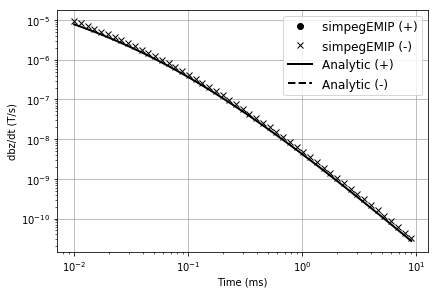

In [4]:
ms = 1e3
# scale = 1./(13**2 *np.pi)
scale = 1
plt.loglog(rx.times*ms, data.flatten()*scale, 'ko', markerfacecolor="k")
plt.loglog(rx.times*ms, -data.flatten()*scale, 'kx', markerfacecolor="k")
plt.loglog(rx.times*ms, -dhzdt.flatten(), 'k-', lw=2)
plt.loglog(rx.times*ms, dhzdt.flatten(), 'k--', lw=2)
plt.grid(True)
plt.tight_layout()
plt.xlabel("Time (ms)")
plt.ylabel("dbz/dt (T/s)")
plt.legend(("simpegEMIP (+)", "simpegEMIP (-)", "Analytic (+)", "Analytic (-)"), fontsize = 12)
uncert = abs(dhzdt)*0.2 + 1e-10
err = np.linalg.norm((data - dhzdt)/(uncert))**2 / survey.nD
rerr = (data - dhzdt)/uncert
print (err)
print (rerr)